# ELBO Bound

In [1]:
import os

import wandb
import tikzplotlib
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from gpflow import default_float
from gpflow.likelihoods import Gaussian

from docs.sde.ou.ou_generate_data import generate_data, plot_data, set_seed
from markovflow.sde.sde import PriorOUSDE
from markovflow.models.cvi_sde import SDESSM
from markovflow.models.vi_sde import VariationalMarkovGP
from docs.sde.sde_exp_utils import get_gpr
from markovflow.kernels.matern import OrnsteinUhlenbeck

2022-07-25 09:13:46.307022: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-07-25 09:13:46.307043: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-07-25 09:13:48.289321: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-07-25 09:13:48.291976: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2022-07-25 09:13:48.314806: E tensorflow/stream_executor/cuda/cuda_driver.cc:328] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2022-07-25 09:13:48.314839: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: verma
2022-07-25 09:13:48.314846: I t

In [2]:
set_seed(66)
os.environ['WANDB_MODE'] = 'offline'
wandb.init(project="VI-SDE")

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


## Data

In [3]:
decay     = .8
q         = .6
x0        = 1.5
t0        = 0.
t1        = 20.
noise_var = 0.01
dt        = 0.01
n_obs     = 40

In [4]:
obs_vals, obs_grid, latent_p, time_grid, _, _  = generate_data(decay, q, x0, t0, t1, noise_var, dt, n_obs)

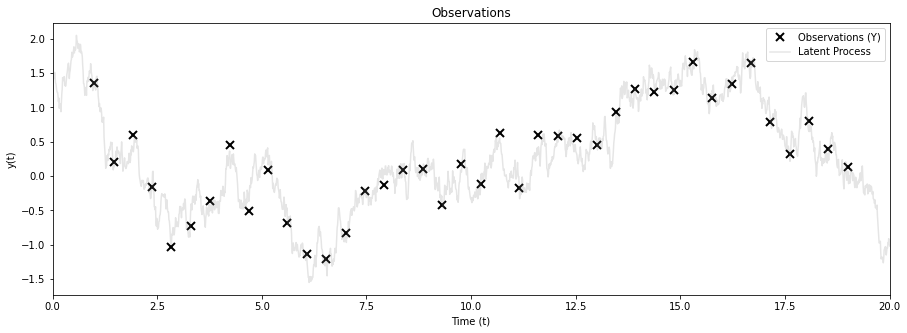

In [5]:
plot_data(obs_grid, obs_vals, time_grid, latent_p, t0, t1, "", None, None)

## Inference and learning

In [6]:
starting_decay = -.2
dt = 0.001

time_grid = tf.cast(np.linspace(t0, t1, int((t1 - t0) // dt) + 2), dtype=time_grid.dtype)

obs_data = (obs_grid, tf.squeeze(obs_vals, axis=0))
DTYPE = default_float()

likelihood = Gaussian(noise_var)

true_q = q * tf.ones((1, 1), dtype=DTYPE)
prior_sde = PriorOUSDE(initial_val=starting_decay, q=true_q)
initial_cov = q / (2 * -1 * starting_decay)  # Steady covariance

### SDE-SSM

In [7]:
ssm_model = SDESSM(input_data=obs_data, prior_sde=prior_sde, grid=time_grid, likelihood=likelihood,
                   learning_rate=1., prior_params_lr=.005)

# Setting initial state statistics
ssm_model.initial_mean = tf.zeros_like(ssm_model.initial_mean)
ssm_model.initial_chol_cov = tf.cast(tf.linalg.cholesky(tf.reshape(initial_cov, ssm_model.initial_chol_cov.shape)),
                                    dtype=DTYPE)
ssm_model.fx_covs = ssm_model.initial_chol_cov.numpy().item()**2 + 0 * ssm_model.fx_covs
ssm_model._linearize_prior()

# Performing inference
ssm_elbo, ssm_prior_prior_vals = ssm_model.run(update_prior=True)

2022-07-25 09:13:55.882718: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


SSM: Starting ELBO -4248.029438549293;
SSM: ELBO -30.860899772819966!!!
SSM: ELBO -30.86089977281996!!!
SSM: Sites Converged!!!
SSM: ELBO -30.86089977281996!!!
SSM: Sites Converged!!!
SSM: ELBO converged!!!
SSM: Prior SDE (learnt and) re-linearized: ELBO -30.676290862250834;!!!
SSM: ELBO -30.67629086225083!!!
SSM: Sites Converged!!!
SSM: ELBO converged!!!
SSM: Prior SDE (learnt and) re-linearized: ELBO -30.53812505971703;!!!
SSM: ELBO -30.538125059717025!!!
SSM: Sites Converged!!!
SSM: ELBO converged!!!
SSM: Prior SDE (learnt and) re-linearized: ELBO -30.43391385482832;!!!
SSM: ELBO -30.433913854828326!!!
SSM: Sites Converged!!!
SSM: ELBO converged!!!
SSM: Prior SDE (learnt and) re-linearized: ELBO -30.354986667865774;!!!
SSM: ELBO -30.354986667865766!!!
SSM: Sites Converged!!!
SSM: ELBO converged!!!
SSM: Prior SDE (learnt and) re-linearized: ELBO -30.29510418030949;!!!
SSM: ELBO -30.29510418030949!!!
SSM: Sites Converged!!!
SSM: ELBO converged!!!
SSM: Prior SDE (learnt and) re-lineari

## VGP

In [12]:
prior_sde = PriorOUSDE(initial_val=starting_decay, q=true_q)
vgp_model = VariationalMarkovGP(input_data=obs_data,
                                prior_sde=prior_sde, grid=time_grid, likelihood=likelihood,
                                lr=.5, initial_state_lr=.5, prior_params_lr=.005)

vgp_model.p_initial_cov = tf.cast(tf.reshape(initial_cov, vgp_model.p_initial_cov.shape), dtype=DTYPE)
vgp_model.q_initial_cov = tf.identity(vgp_model.p_initial_cov)
vgp_model.p_initial_mean = tf.zeros_like(vgp_model.p_initial_mean)
vgp_model.q_initial_mean = tf.identity(vgp_model.p_initial_mean)

vgp_model.A = -1 * starting_decay + 0. * vgp_model.A

v_gp_elbo, v_gp_prior_vals = vgp_model.run(update_prior=True)

VGP: Starting ELBO -4248.02941516054
VGP - q loop: ELBO -1891.6974308398474
VGP - q loop: ELBO -1551.2028669301894
VGP - q loop: ELBO -1286.6474794438118
VGP - q loop: ELBO -1067.0583239167488
VGP - q loop: ELBO -878.5136664263716
VGP - q loop: ELBO -714.5916015923906
VGP - q loop: ELBO -572.71723376231
VGP - q loop: ELBO -451.93180767282377
VGP - q loop: ELBO -350.96727362184066
VGP - q loop: ELBO -266.55213510792737
VGP - q loop: ELBO -194.17615281405847
VGP - q loop: ELBO -132.50448938488339
VGP - q loop: ELBO -85.30618844338274
VGP - q loop: ELBO -55.86647864682867
VGP - q loop: ELBO -41.445742322742305
VGP - q loop: ELBO -35.76151435154098
VGP - q loop: ELBO -33.86067867646612
VGP - q loop: ELBO -33.294882286296854
VGP - q loop: ELBO -33.139602732316305
VGP - q loop: ELBO -33.09926644996597
VGP - x0 loop: ELBO -31.92747864197563
VGP - q loop: ELBO -31.91324525755508
VGP - q loop: ELBO -31.909678945065725
VGP - q loop: ELBO -31.908802899322144
VGP - q loop: ELBO -31.908592830650083

## ELBO

<Figure size 1080x360 with 0 Axes>

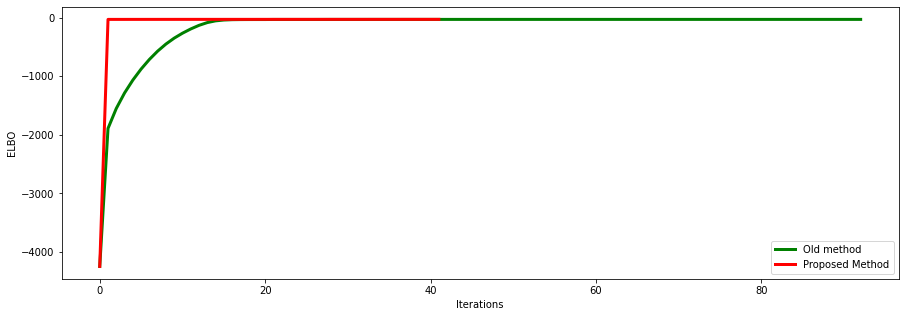

In [13]:
plt.clf()
fig, _ = plt.subplots(1, 1)

plt.plot(v_gp_elbo, label="Old method", color="green", linewidth=3.)
plt.plot(ssm_elbo, label="Proposed Method", color="red", linewidth=3.)
plt.xlabel("Iterations")
plt.ylabel("ELBO")
plt.legend()

# tikzplotlib.save('elbo_iterations.tex', figure=fig)

plt.show()

## Plotting

/home/prakhar/anaconda3/envs/markovflow/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "kx" (-> color='k'). The keyword argument will take precedence.
  after removing the cwd from sys.path.
/home/prakhar/anaconda3/envs/markovflow/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "kx" (-> color='k'). The keyword argument will take precedence.
  """


<Figure size 1080x360 with 0 Axes>

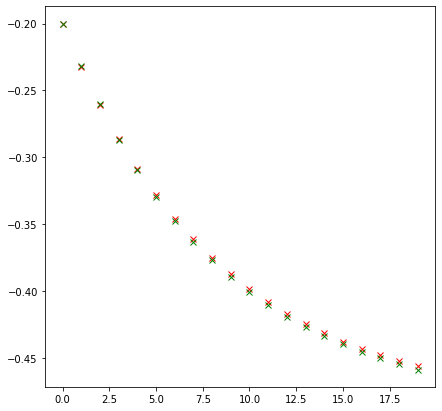

In [14]:
plt.clf()
fig, _  = plt.subplots(1, 1, figsize=(7, 7))

plt.plot(ssm_prior_prior_vals[0],'kx', label="Proposed Method", color="red")
plt.plot(v_gp_prior_vals[0],'kx', label="Old method", color="green")
# tikzplotlib.save('elbo_bound.tex', figure=fig)

plt.show()